# Construction of the Gaussian white noise model from the experiment associated with the density estimation problem in the data driven way

In [1]:
import numpy as np
import os
import scipy.integrate as integrate
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy.stats import reciprocal
from scipy.stats import truncnorm
import time

In [2]:
def mt_png_examples_path():
    return './images'

In [3]:
# --- functions from part 1 ---

def get_unit_interval_unif_partition(m):
    return np.array([[i / m, (i + 1) / m] for i in range(m)])


def get_partition_midpoints(m):
    return np.around(np.mean(get_unit_interval_unif_partition(m), axis=1), 5)


def get_scaled_compact_pdf(pdf_func, f_supp_min, f_supp_max):
    scale_factor = f_supp_max - f_supp_min
    def scaled_pdf(x):
        if isinstance(x, (float, int)):
            return pdf_func(x * scale_factor + f_supp_min)
        else:
            return pdf_func(np.array(x) * scale_factor + f_supp_min)
    return scaled_pdf, scale_factor


def get_sqrt_pdf_func(pdf_func):
    def sqrt_pdf_func(x):
        return np.sqrt(pdf_func(x))
    return sqrt_pdf_func


def get_unit_interval_unif_partition(m):
    return np.array([[i / m, (i + 1) / m] for i in range(m)])


def get_partition_midpoints(m):
    return np.around(np.mean(get_unit_interval_unif_partition(m), axis=1), 5)


def pdf_integ(pdf_func, lower_bound, upper_bound, scale_factor=1):
    # scale_factor: see get_scaled_compact_pdf()
    return integrate.quad(pdf_func, lower_bound, upper_bound)[0] * scale_factor


def get_thetas_vector_scaled_pdf(scaled_pdf_func, m, scale_factor=1):
    partition = get_unit_interval_unif_partition(m)
    thetas = []
    for p in partition:
        thetas.append(round(pdf_integ(pdf_func=scaled_pdf_func, lower_bound=p[0], upper_bound=p[1],
                                      scale_factor=scale_factor),
                            5))
    return np.array(thetas)


def split_intelval_to_negative_positive(a, b):
    assert(a <= b)
    if a < 0:
        if b < 0:
            return [[a, b], [0, 0]]
        else:
            return [[a, 0], [0, b]]
    else:
        return [[0, 0], [a, b]]


def t_integ(i, m, lower_bound, upper_bound):
    midpoint = get_partition_midpoints(m)[i]
    lower_bound = lower_bound - midpoint
    upper_bound = upper_bound - midpoint
    neg_part, pos_part = split_intelval_to_negative_positive(lower_bound, upper_bound)
    result = ((upper_bound - lower_bound) * m) - (m ** 2 * \
                (((pos_part[1] ** 2  - pos_part[0] ** 2) / 2) + \
                     ((np.abs(neg_part[0]) ** 2)  - np.abs(neg_part[1]) ** 2) / 2))
    return round(result, 5)


def get_intervals_intersection(a1, b1, a2, b2):
    assert(a1 <= b1 and a2 <= b2)
    if a1 <= a2 and b1 <= b2:
        if b1 < a2:
            return None
        a_inters = min(a2, b1)
        b_inters = max(a2, b1)
    elif a1 > a2 and b1 > b2:
        if b2 < a1:
            return None
        a_inters = min(a1, b2)
        b_inters = max(a1, b2)
    else:
        a_inters = max(a1, a2)
        b_inters = min(b1, b2)
    if a_inters <= b_inters:
        return [a_inters, b_inters]
    else:
        return None


def v_integ(i, m, lower_bound, upper_bound):
    # for i = 0, ..., m - 1
    midpoints = get_partition_midpoints(m)
    result = 0
    if i == 0:
        inters1 = get_intervals_intersection(0, midpoints[0], lower_bound, upper_bound)
        if inters1 is not None:
            result += m * (inters1[1] - inters1[0])
        inters2 = get_intervals_intersection(midpoints[0], midpoints[1], lower_bound, upper_bound)
        if inters2 is not None:
            result += t_integ(i, m, inters2[0], inters2[1])
    elif 0 < i < m - 1:
        inters1 = get_intervals_intersection(midpoints[i - 1], midpoints[i + 1], lower_bound, upper_bound)
        if inters1 is not None:
            result += t_integ(i, m, inters1[0], inters1[1])
    elif i == m - 1:
        result = 0
        inters1 = get_intervals_intersection(midpoints[m - 1], 1, lower_bound, upper_bound)
        if inters1 is not None:
            result += m * (inters1[1] - inters1[0])
        inters2 = get_intervals_intersection(midpoints[m - 2], midpoints[m - 1], lower_bound, upper_bound)
        if inters2 is not None:
            result += t_integ(i, m, inters2[0], inters2[1])
    return result

## Reciprocal probability density function

In this part we are aiming to construct the Gaussian white noise model from the experiment associated with the density estimation problem in the data driven way. As an example we, again, consider simulation sampled generated from the reciprocal (or log-uniform) probability density function. As before, based on the analytical results from the part 1, we choose $m = \sqrt{n}$.

In [4]:
def make_simulation(rvs_generator, samples_nb, random_seed=None):
    # rvs_generator: function taking number of samples to generate as an argument
    if not (random_seed is None):
        np.random.seed(random_seed)
    return rvs_generator(samples_nb)


def plot_distr_samples(samples, name=None, img_name=None, pdf_func=None, out_path=None):
    text_size=16
    plt.style.use('seaborn-muted')
    rcParams['font.family'] = 'serif'
    rcParams['mathtext.fontset'] = 'dejavuserif'
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
    x = range(len(samples))
    axs[0].hist(samples, histtype='step', alpha=0.7, bins=int(np.sqrt(len(samples))), color='darkblue')
    if pdf_func is not None:
        ax2 = axs[0].twinx()
        x_pdf = np.linspace(min(samples), max(samples), 1000)
        ax2.plot(x_pdf, pdf_func(x_pdf), color='orangered', label='underlying PDF (right axis)')
        ax2.legend(fontsize=text_size)
        ax2.tick_params(axis='both', which='major', labelsize=text_size)
    axs[0].tick_params(axis='both', which='major', labelsize=text_size)
    axs[0].set_ylabel('Frequency', fontsize=text_size)
    axs[1].plot(x, samples, alpha=0.7, color='darkblue')
    axs[1].set_ylabel('Sample value', fontsize=text_size)
    axs[1].tick_params(axis='both', which='major', labelsize=text_size)
    if name is not None:
        axs[0].set_title(name, fontsize=text_size)
        axs[1].set_title(name, fontsize=text_size)
    plt.tight_layout()
    if out_path is not None:
        if img_name is None:
            img_name = 'samples_distribution'
        plt.savefig(os.path.join(out_path, '{}_{}.png'.format(time.strftime('%Y%M%d_%H%M%S'), img_name)),
                    quality=100, dpi=500)
    plt.show()

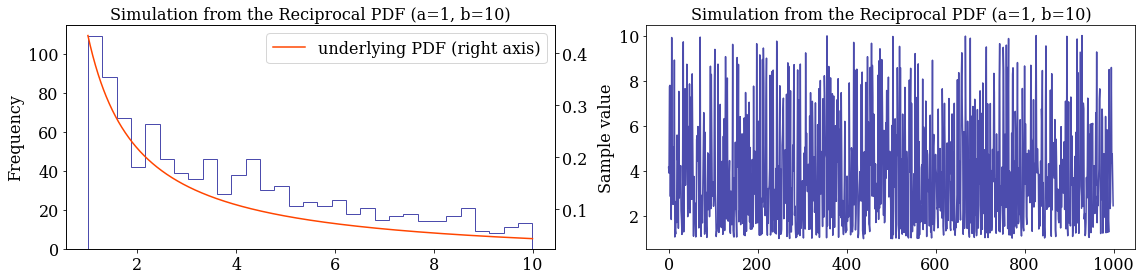

In [5]:
a = 1
b = 10
rvs_reciprocal_generator = reciprocal(a, b).rvs
pdf_func = reciprocal(a, b).pdf
simulation_samples = make_simulation(rvs_reciprocal_generator, samples_nb=1000, random_seed=1234567890)
plot_distr_samples(simulation_samples, name='Simulation from the Reciprocal PDF (a=1, b=10)',
                   pdf_func=pdf_func, img_name='reciprocal_samples', out_path=mt_png_examples_path())

We scale the obsetvations to the unit interval.

In [6]:
def get_scaled_simulation(simulation_samples):
    scaled_simulation_samples = (simulation_samples - min(simulation_samples)) / \
                                    (max(simulation_samples) - min(simulation_samples))
    scale_factor = max(simulation_samples) - min(simulation_samples)
    return scaled_simulation_samples, scale_factor

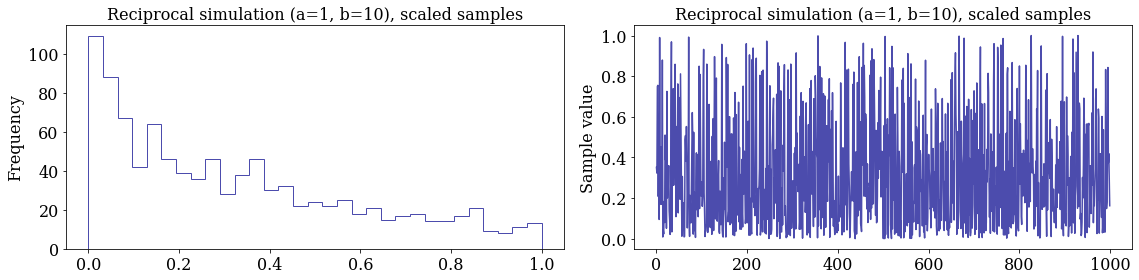

In [7]:
scaled_simulation_samples, scale_factor = get_scaled_simulation(simulation_samples)

plot_distr_samples(scaled_simulation_samples, name='Reciprocal simulation (a=1, b=10), scaled samples',
                   img_name='reciprocal_samples', out_path=mt_png_examples_path())

### Step 1: Multinomial approximation

In [8]:
def get_multinomial_from_scaled_simulation_samples(scaled_simulation_samples):
    m = int(np.sqrt(len(scaled_simulation_samples)))
    partition = get_unit_interval_unif_partition(m)
    multinomial_count = np.zeros(m)
    for i, part in enumerate(partition):
        if i == len(partition) - 1:
            count = len(np.where((part[0] <= scaled_simulation_samples) & \
                                         (scaled_simulation_samples <= part[1]))[0])
        else:
            count = len(np.where((part[0] <= scaled_simulation_samples) & \
                                         (scaled_simulation_samples < part[1]))[0])
        multinomial_count[i] = count
    return multinomial_count.astype(np.int)

In [9]:
def plot_multinomial_sample(multinomial_sample, out_path=None):
    text_size = 16
    plt.style.use('seaborn-muted')
    rcParams['font.family'] = 'serif'
    rcParams['mathtext.fontset'] = 'dejavuserif'
    x_grid = np.array(list(range(len(multinomial_sample))))
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
    ax.bar(x_grid, multinomial_sample, color='crimson')
    ax.tick_params(axis='both', which='major', labelsize=text_size)
    title_str = 'Derived observation from the multinomial model'
    ax.set_title(title_str, fontsize=text_size)
    ax.grid(True)
    ax.set_ylim([0.0, None])
    ax.set_xlabel('$i$', fontsize=text_size)
    ax.set_ylabel('$\# \{j: x_j \in J_i\}$', fontsize=text_size)
    ax.set_xticks(x_grid[[0, int(0.25 * len(x_grid)), int(0.5 * len(x_grid)), int(0.75 * len(x_grid)), -1]])
    ax.set_xticklabels(x_grid[[0, int(0.25 * len(x_grid)),
                               int(0.5 * len(x_grid)), int(0.75 * len(x_grid)), -1]] + 1)
    plt.tight_layout()
    if out_path is not None:
        plt.savefig(os.path.join(out_path, '{}_multinomial_sample.png'.format(time.strftime('%Y%M%d_%H%M%S'))),
                    quality=100, dpi=500)
    plt.show()

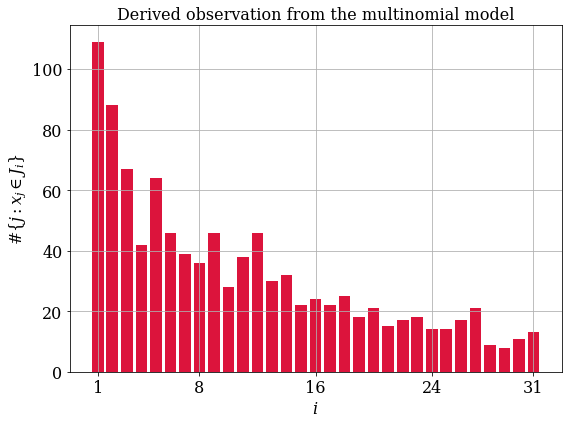

In [10]:
multinomial_sample = get_multinomial_from_scaled_simulation_samples(scaled_simulation_samples)
plot_multinomial_sample(multinomial_sample, out_path=mt_png_examples_path())

### Step 2: Gaussian approximation (with independent coordinates)

In [11]:
def multinom_thetas_mle(multinom_simulation):
    return multinom_simulation / np.sum(multinom_simulation)

In [12]:
def plot_thetas_mle(thetas_mle, out_path=None):
    text_size = 16
    plt.style.use('seaborn-muted')
    rcParams['font.family'] = 'serif'
    rcParams['mathtext.fontset'] = 'dejavuserif'
    x_grid = np.array(list(range(len(thetas_mle))))
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
    ax.bar(x_grid, thetas_mle, color='teal')
    ax.tick_params(axis='both', which='major', labelsize=text_size)
    title_str = 'MLE of $\\theta$ from the Multinomial approximation'
    ax.set_title(title_str, fontsize=text_size)
    ax.grid(True)
    ax.set_ylim([0.0, None])
    ax.set_xlabel('$i$', fontsize=text_size)
    ax.set_ylabel('$\^\\theta^{MLE}_i$', fontsize=text_size)
    ax.set_xticks(x_grid[[0, int(0.25 * len(x_grid)), int(0.5 * len(x_grid)), int(0.75 * len(x_grid)), -1]])
    ax.set_xticklabels(x_grid[[0, int(0.25 * len(x_grid)),
                               int(0.5 * len(x_grid)), int(0.75 * len(x_grid)), -1]] + 1)
    plt.tight_layout()
    if out_path is not None:
        plt.savefig(os.path.join(out_path, '{}_thetas_mle.png'.format(time.strftime('%Y%M%d_%H%M%S'))),
                    quality=100, dpi=500)
    plt.show()

MLE of thetas from multinomial experiment:
	( 0.109  0.088  0.067  0.042  0.064  0.046  0.039  0.036  0.046  0.028  0.038  0.046  0.030  0.032  0.022  0.024  0.022  0.025  0.018  0.021  0.015  0.017  0.018  0.014  0.014  0.017  0.021  0.009  0.008  0.011  0.013 )


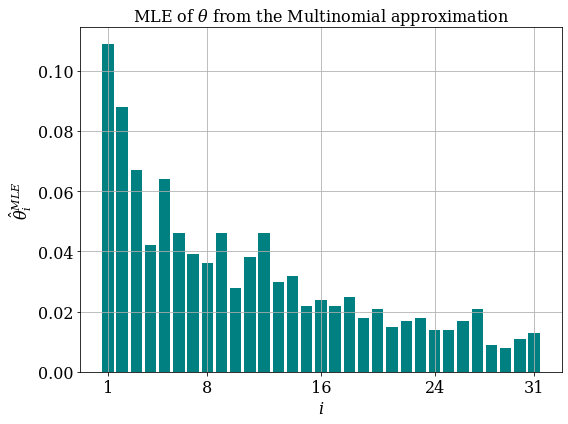

In [13]:
thetas_mle = multinom_thetas_mle(multinomial_sample)
print('MLE of thetas from multinomial experiment:\n\t(', end='')
for t in thetas_mle:
    print('{:>6.3f} '.format(t), end='')
print(')')

plot_thetas_mle(thetas_mle, out_path=mt_png_examples_path())

In [14]:
def get_indep_gaussian_from_multinom(multinomial_sample, scale_factor=1, random_seed=None):
    if random_seed is not None:
        np.random.seed(random_seed)
    m = len(multinomial_sample)
    n = sum(multinomial_sample)
    scaled_thetas_mle = multinom_thetas_mle(multinomial_sample)
    simulation = []
    for i in range(m):
        mean = np.sqrt((scaled_thetas_mle[i] * scale_factor) / m)
        var = 1 / (4 * n * m)
        simulation.append(np.random.normal(loc=mean, scale=np.sqrt(var)))
    return np.array(simulation)

In [15]:
print('Simulation sample from independent Gaussians experiment:\n\t|', end='')
for s in get_indep_gaussian_from_multinom(multinomial_sample, scale_factor=scale_factor, random_seed=123450):
    print('{:>5.3f} |'.format(s), end='')
print('\n')

Simulation sample from independent Gaussians experiment:
	|0.179 |0.160 |0.137 |0.112 |0.133 |0.117 |0.106 |0.103 |0.116 |0.091 |0.102 |0.111 |0.091 |0.097 |0.076 |0.081 |0.081 |0.080 |0.074 |0.081 |0.067 |0.065 |0.067 |0.067 |0.067 |0.069 |0.076 |0.055 |0.046 |0.058 |0.061 |



$\mathcal{N}^*_m$ is the statistical model associated with the observation of the increments of $\left(y_t\right)_t$ over the intervals $J_i, \; i = 1, . . . ,m$. Let us simulate some trajectories of $\left(y_t\right)_t$ using estimated $\theta$ from the multinomial model.

In [16]:
def get_path_over_unif_interval(multinomial_sample, scale_factor=1, random_seed=None):
    if not (random_seed is None):
        np.random.seed(random_seed)
    values = get_indep_gaussian_from_multinom(multinomial_sample, scale_factor=scale_factor)
    m = len(multinomial_sample)
    t_grid = get_unit_interval_unif_partition(m).T[1]
    return np.cumsum(values, axis=-1), t_grid


def plot_pathes_over_unif_interval(multinomial_sample, scale_factor=1, simulations_nb=50,
                                   random_seed=None, out_path=None):
    if not (random_seed is None):
        np.random.seed(random_seed)
    text_size = 16
    plt.style.use('seaborn-muted')
    rcParams['font.family'] = 'serif'
    rcParams['mathtext.fontset'] = 'dejavuserif'
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
    for i in range(simulations_nb):
        values, t_grid = get_path_over_unif_interval(multinomial_sample, scale_factor=scale_factor)
        values = [0] + values.tolist()
        t_grid = [0] + t_grid.tolist()
        ax.plot(t_grid, values, marker='o', markeredgecolor='black', alpha=0.5)
    t_grid = np.array(t_grid)
    ax.tick_params(axis='both', which='major', labelsize=text_size)
    ax.grid(True)
    ax.set_xlabel('$t$', fontsize=text_size)
    ax.set_xticks(t_grid[[0, int(0.25 * len(t_grid)), int(0.5 * len(t_grid)), int(0.75 * len(t_grid)), -1]])
    ax.set_xticklabels(np.round(t_grid[[0, int(0.25 * len(t_grid)),
                                       int(0.5 * len(t_grid)), int(0.75 * len(t_grid)), -1]], 2))
    plt.tight_layout()
    if out_path is not None:
        plt.savefig(os.path.join(out_path,
                                 '{}_pathes_over_unif_interval.png'.format(time.strftime('%Y%M%d_%H%M%S'))),
                    quality=100, dpi=500)
    plt.show()

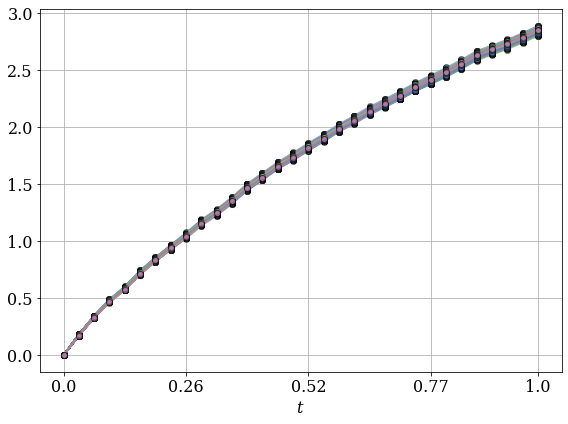

In [17]:
plot_pathes_over_unif_interval(multinomial_sample, scale_factor=scale_factor, simulations_nb=1000,
                               random_seed=678333, out_path=mt_png_examples_path())

### Steps 3-4: Gaussian white noise model from the Gaussian approximation

In [18]:
def sqrt_f_est_integ(t, thetas, m):
    if isinstance(t, (float, int)):
        f = 0
        for i in range(m):
            f += v_integ(i, m, 0, t) * thetas[i]
        return f
    else:
        f_values = []
        for t_i in t:
            f = 0
            for i in range(m):
                f += v_integ(i, m, 0, t_i) * thetas[i]
            f_values.append(f)
        return np.array(f_values)

In [26]:
def plot_sqrt_cdf_approx(multinomial_sample, n=1000, scale_factor=1, scaled_sqrt_pdf_func=None, out_path=None):
    scaled_thetas_mle = multinom_thetas_mle(multinomial_sample)
    m = len(multinomial_sample)
    thetas_mle = np.sqrt((scaled_thetas_mle * scale_factor) / m)
    text_size = 16
    plt.style.use('seaborn-muted')
    rcParams['font.family'] = 'serif'
    rcParams['mathtext.fontset'] = 'dejavuserif'
    t_grid = np.linspace(0, 1, n)
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
    for i in range(len(thetas_mle)):
        if i == 0:
            label = '$( \int_{J_i} \sqrt{f(y)}dy ) \cdot \int^t_0 V_i(y)dy, \; i=1,...,m$'
        else:
            label = None
        ax.plot(t_grid, [v_integ(i, m, 0, t) * thetas_mle[i] for t in t_grid], c='gray', lw=0.5, label=label)
    if scaled_sqrt_pdf_func is not None:
        ax.plot(t_grid, [pdf_integ(scaled_sqrt_pdf_func, 0, t, scale_factor) for t in t_grid],
                color='indigo', label='True Squared CDF $\int^t_0 \sqrt{f(y)}dy$')
    ax.plot(t_grid, sqrt_f_est_integ(t_grid, thetas_mle, m),
            color='orange', label='$\int^t_0 \^\sqrt{f_m}(y)dy$' + ' for $m=${}'.format(m))
    ax.tick_params(axis='both', which='major', labelsize=text_size)
    ax.set_ylim([0.0, None])
    ax.set_xlabel('$t$', fontsize=text_size)
    ax.set_title('Approximation of Squared CDF', fontsize=text_size)
    handles, labels = plt.gca().get_legend_handles_labels()
    order = [1,0,2]
    ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
              fontsize=text_size, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    if out_path is not None:
        plt.savefig(os.path.join(out_path,
                                 '{}_sqrt_cdf_approx_m{}.png'.format(time.strftime('%Y%M%d_%H%M%S'), m)),
                    quality=100, dpi=500)
    plt.show()

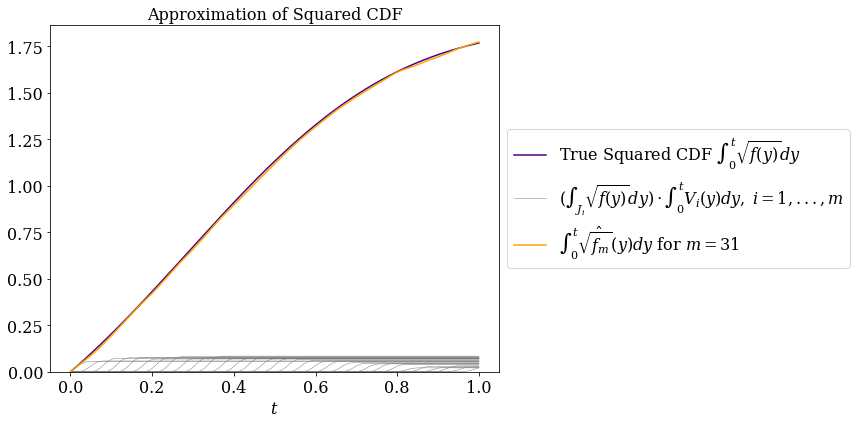

In [27]:
scaled_pdf_func, scale_factor = get_scaled_compact_pdf(pdf_func, f_supp_min=a, f_supp_max=b)
scaled_sqrt_pdf_func = get_sqrt_pdf_func(scaled_pdf_func)
plot_sqrt_cdf_approx(multinomial_sample, scaled_sqrt_pdf_func=scaled_sqrt_pdf_func,
                    scale_factor=scale_factor, out_path=mt_png_examples_path())

---
## Truncated normal probability density function

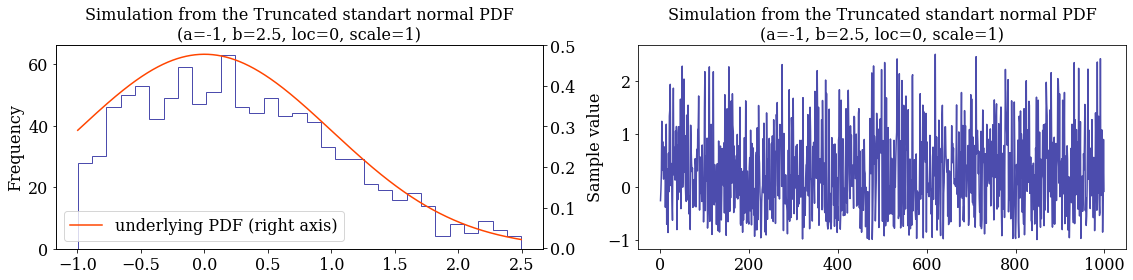

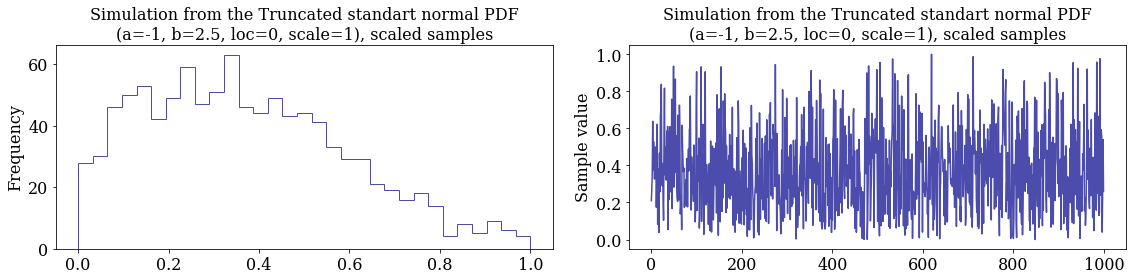

In [21]:
a = -1
b = 2.5
rvs_truncnorm_generator = truncnorm(a, b).rvs
pdf_func = truncnorm(a, b).pdf
simulation_samples = make_simulation(rvs_truncnorm_generator, samples_nb=1000, random_seed=8761)
pdf_name = 'Simulation from the Truncated standart normal PDF\n(a=-1, b=2.5, loc=0, scale=1)'
plot_distr_samples(simulation_samples, name=pdf_name,
                   img_name='truncnorm_samples', pdf_func=pdf_func, out_path=mt_png_examples_path())

scaled_simulation_samples, scale_factor = get_scaled_simulation(simulation_samples)
plot_distr_samples(scaled_simulation_samples,
                   name=pdf_name + ', scaled samples',
                   img_name='truncnorm_samples', out_path=mt_png_examples_path())

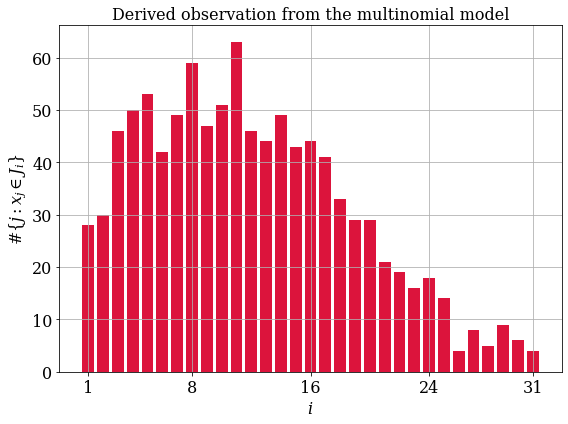

In [22]:
multinomial_sample = get_multinomial_from_scaled_simulation_samples(scaled_simulation_samples)
plot_multinomial_sample(multinomial_sample, out_path=mt_png_examples_path())

MLE of thetas from multinomial experiment:
	( 0.028  0.030  0.046  0.050  0.053  0.042  0.049  0.059  0.047  0.051  0.063  0.046  0.044  0.049  0.043  0.044  0.041  0.033  0.029  0.029  0.021  0.019  0.016  0.018  0.014  0.004  0.008  0.005  0.009  0.006  0.004 )


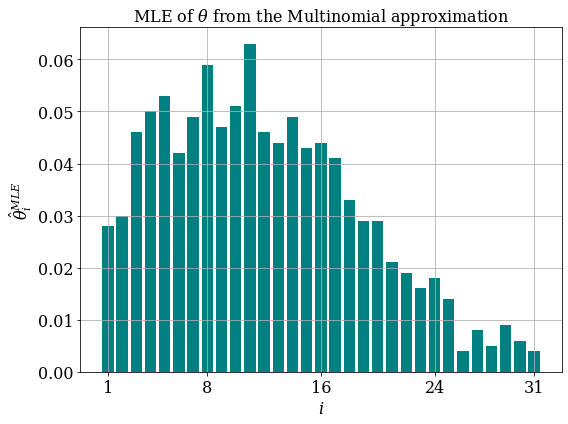

In [23]:
thetas_mle = multinom_thetas_mle(multinomial_sample)
print('MLE of thetas from multinomial experiment:\n\t(', end='')
for t in thetas_mle:
    print('{:>6.3f} '.format(t), end='')
print(')')

plot_thetas_mle(thetas_mle, out_path=mt_png_examples_path())

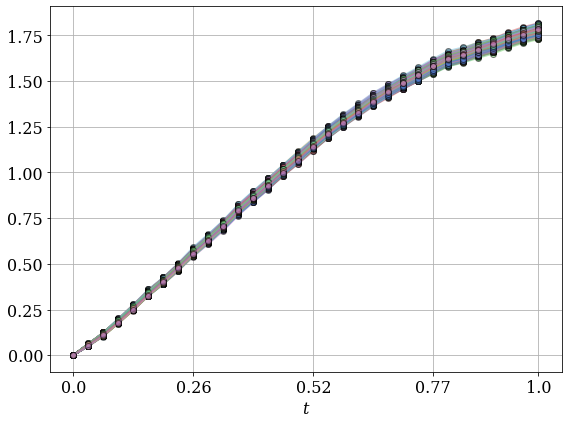

In [24]:
plot_pathes_over_unif_interval(multinomial_sample, scale_factor=scale_factor, simulations_nb=1000,
                               random_seed=678333, out_path=mt_png_examples_path())

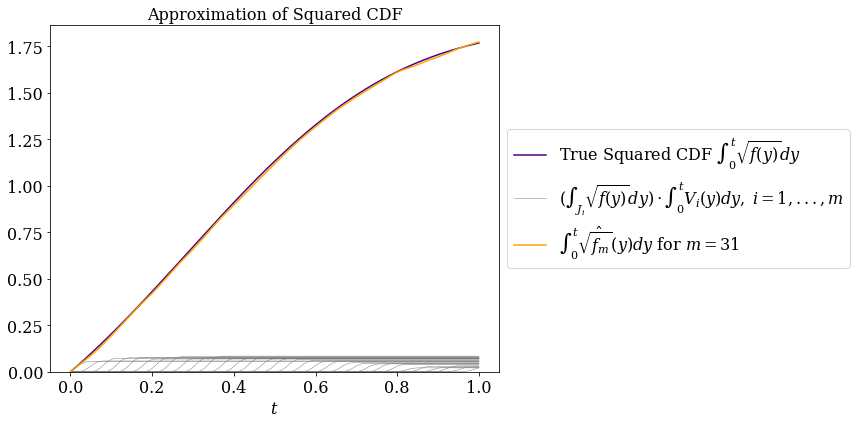

In [28]:
pdf_func = truncnorm(a, b).pdf
scaled_pdf_func, scale_factor = get_scaled_compact_pdf(pdf_func, f_supp_min=a, f_supp_max=b)
scaled_sqrt_pdf_func = get_sqrt_pdf_func(scaled_pdf_func)
plot_sqrt_cdf_approx(multinomial_sample, scaled_sqrt_pdf_func=scaled_sqrt_pdf_func,
                    scale_factor=scale_factor, out_path=mt_png_examples_path())